In [1]:
# Making some data
from sklearn.datasets import make_circles
N = 1000

X, y = make_circles(n_samples=N, noise=0.1, random_state = 42)

In [3]:
import pandas as pd

circles = pd.DataFrame({'X0':X[:,0], 'X1':X[:,1], 'label':y})
circles.head(10)

,X0,X1,label
0,0.712108,0.284698,1
1,-0.678716,0.207274,1
2,-0.866026,0.343651,1
3,-0.517648,0.620599,1
4,0.454089,-0.890466,0
5,-0.445483,0.787044,1
6,-0.022038,0.811310,1
7,0.729897,0.188943,1
8,-0.191616,-0.815790,1
9,-0.083442,1.093954,0


In [4]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

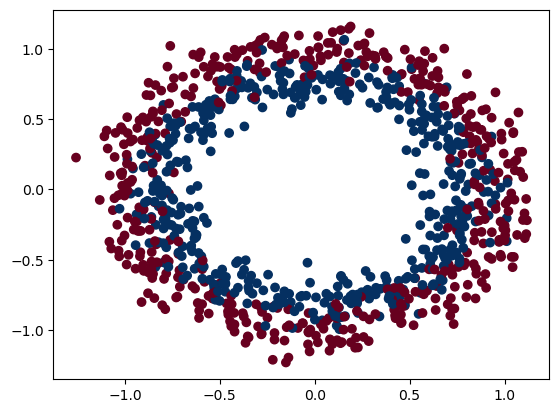

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu)
plt.show()

In [6]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps
                      .is_available()
else 'cpu')

device

device(type='cpu')

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=10)
        self.linear2 = nn.Linear(in_features=10, out_features=10)
        self.linear4 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear4(x)

        return x

In [59]:
model = SimpleModel().to(device)

from torchinfo import summary

summary(model, input_size=(1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleModel                              [1, 1]                    --
├─Linear: 1-1                            [1, 10]                   30
├─ReLU: 1-2                              [1, 10]                   --
├─Linear: 1-3                            [1, 10]                   110
├─ReLU: 1-4                              [1, 10]                   --
├─Linear: 1-5                            [1, 1]                    11
Total params: 151
Trainable params: 151
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [60]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
def accuracy_cal(y_pred, label):
    correct = torch.eq(y_pred, label).sum().item()
    return correct / label.shape[0] * 100

In [63]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for i in range(epochs):
    model.train()
    y_hat = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_hat))

    loss = loss_fn(y_hat, y_train)
    acc = accuracy_cal(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_hat_test = model(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(y_hat_test))

        loss_test = loss_fn(y_hat_test, y_test)
        acc_test = accuracy_cal(y_pred_test, y_test)

    if (i+1) % 10 == 0:
        print(f'Epoch: {i+1}/{epochs}, Train loss: {loss.item():.4f}, Train acc: {acc:.2f}%, Test loss: {loss_test.item():.4f}, Test acc: {acc_test:.2f}%')



Epoch: 10/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5952, Test acc: 73.50%
Epoch: 20/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5953, Test acc: 73.50%
Epoch: 30/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5952, Test acc: 73.50%
Epoch: 40/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5952, Test acc: 73.50%
Epoch: 50/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5952, Test acc: 73.50%
Epoch: 60/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5953, Test acc: 73.50%
Epoch: 70/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5953, Test acc: 73.50%
Epoch: 80/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5954, Test acc: 73.50%
Epoch: 90/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5953, Test acc: 73.50%
Epoch: 100/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5955, Test acc: 73.50%
Epoch: 110/1000, Train loss: 0.3171, Train acc: 86.12%, Test loss: 0.5954, Test acc: 73.5

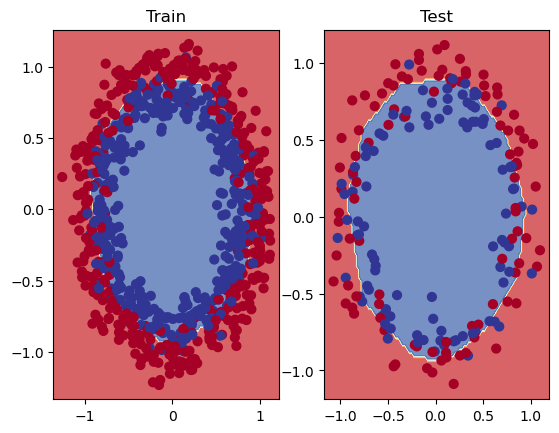

In [64]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure()
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)
plt.show()

In [66]:
model.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model(X_test))).squeeze()

'Accuracy: ', accuracy_cal(y_pred, y_test)


('Accuracy: ', 73.5)

### Multiclass classification

In [87]:
from sklearn.datasets import make_blobs

CLASS_NUM = 4
X_blob, y_blob = make_blobs(n_samples=N,
                            n_features=2,
                            centers=CLASS_NUM,
                            random_state=42,
                            cluster_std=1.5)

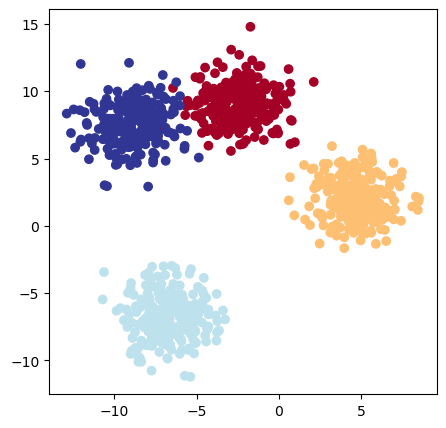

In [88]:
# visualize the data
plt.figure(figsize=(5, 5))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()


In [89]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [92]:
class BolbModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_size):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(in_features, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, out_features))

    def forward(self, x):
        x = self.linear(x)
        return x

model_blob = BolbModel(in_features=2, out_features=4, hidden_size=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_blob.parameters(), lr=0.001)




In [94]:
torch.manual_seed(42)

epochs = 250

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for i in range(epochs):
    model_blob.train()
    y_logits = model_blob(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_cal(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_blob.eval()
    with torch.inference_mode():
        y_logits_test = model_blob(X_test)
        y_pred_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)

        loss_test = loss_fn(y_logits_test, y_test)
        acc_test = accuracy_cal(y_pred_test, y_test)

    if (i+1) % 10 == 0:
        print(f'Epoch: {i+1}/{epochs}, Train loss: {loss.item():.4f}, Train acc: {acc:.2f}%, Test loss: {loss_test.item():.4f}, Test acc: {acc_test:.2f}%')

Epoch: 10/250, Train loss: 0.0207, Train acc: 99.38%, Test loss: 0.0096, Test acc: 99.50%
Epoch: 20/250, Train loss: 0.0206, Train acc: 99.38%, Test loss: 0.0095, Test acc: 99.50%
Epoch: 30/250, Train loss: 0.0205, Train acc: 99.38%, Test loss: 0.0094, Test acc: 99.50%
Epoch: 40/250, Train loss: 0.0204, Train acc: 99.38%, Test loss: 0.0094, Test acc: 99.50%
Epoch: 50/250, Train loss: 0.0204, Train acc: 99.50%, Test loss: 0.0093, Test acc: 99.50%
Epoch: 60/250, Train loss: 0.0203, Train acc: 99.50%, Test loss: 0.0092, Test acc: 99.50%
Epoch: 70/250, Train loss: 0.0202, Train acc: 99.50%, Test loss: 0.0091, Test acc: 99.50%
Epoch: 80/250, Train loss: 0.0202, Train acc: 99.50%, Test loss: 0.0091, Test acc: 99.50%
Epoch: 90/250, Train loss: 0.0201, Train acc: 99.50%, Test loss: 0.0090, Test acc: 99.50%
Epoch: 100/250, Train loss: 0.0200, Train acc: 99.50%, Test loss: 0.0089, Test acc: 99.50%
Epoch: 110/250, Train loss: 0.0199, Train acc: 99.50%, Test loss: 0.0088, Test acc: 99.50%
Epoch: 1

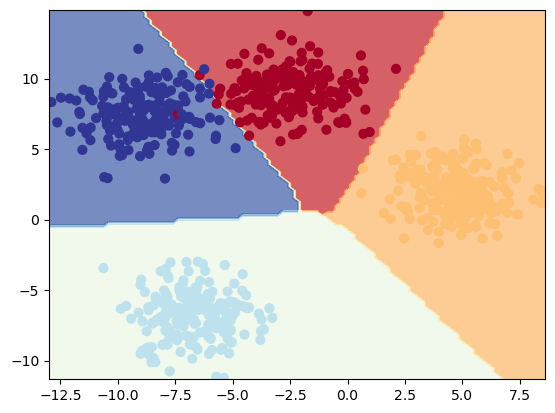

In [95]:
plot_decision_boundary(model_blob, X_train, y_train)

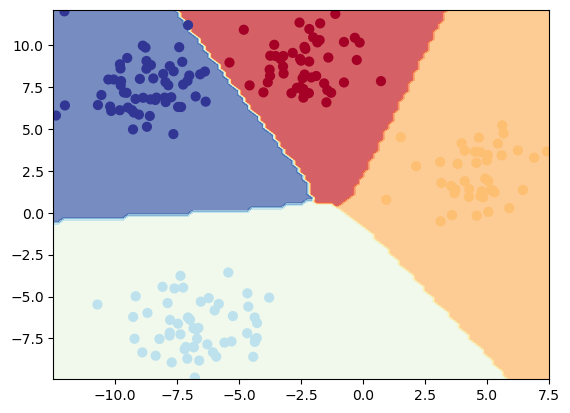

In [96]:
plot_decision_boundary(model_blob, X_test, y_test)

In [97]:
from sklearn.metrics import classification_report

model_blob.eval()
with torch.inference_mode():
    y_logits_test = model_blob(X_test)
    y_pred_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)

print(classification_report(y_test.cpu().numpy(), y_pred_test.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200



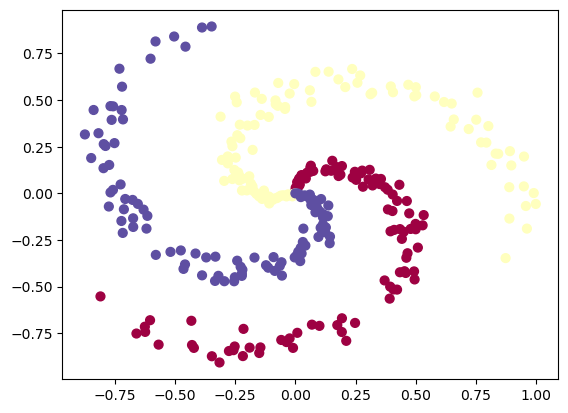

In [98]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()